In [24]:
import sys
#sys.path.append("/usr/local/lib/python3.11/site-packages")
import subprocess
import networkx as nx
import gzip
#import pyfrost
import numpy
from collections import defaultdict
import matplotlib.pyplot as plot
#import CCGG_extension as CCGG
import json
import AGG
import pandas as pd
#import py4cytoscape as p4c
import pysam

In [25]:
# !conda install --yes --prefix {sys.prefix} numpy
# !{sys.executable} -m pip install pysam

In [4]:
def is_circular(read, reference_length, threshold=100):
    """
    Check if a read is circular based on the alignment position and CIGAR string.

    Parameters:
    - read: pysam.AlignedSegment object representing a read.
    - reference_length: Length of the reference genome (circular).
    - threshold: Maximum distance for a read to be considered circular.

    Returns:
    - True if the read is circular, False otherwise.
    """
    if not read.cigartuples:
        return False

    # Get the alignment position and CIGAR string
    start_position = read.reference_start
    cigar = read.cigartuples

    # Calculate the total length of soft-clipped and aligned segments
    read_length = sum(length for op, length in cigar if op in [0, 2, 7, 8])
    
    # Calculate the position of the last aligned base
    end_position = start_position + read_length

    # Calculate the distance from the end position to the start
    distance = numpy.absolute(reference_length - end_position)

    # Check if the read is circular
    return distance <= threshold

def identify_circular_reads(bam_file, circular_reference_length, output_file):
    """
    Identify and save circular reads from a BAM file.

    Parameters:
    - bam_file: Path to the input BAM file.
    - circular_reference_length: Length of the circular reference genome.
    - output_file: Path to the output BAM file for circular reads.
    """
    number_of_reads = []
    with pysam.AlignmentFile(bam_file, 'rb') as bam, pysam.AlignmentFile(output_file, 'wb', template=bam) as circular_bam:
        for read in bam:
            if is_circular(read, circular_reference_length):
                if (len(read.query_sequence) < 17000) and (len(read.query_sequence) > 15000):
                    circular_bam.write(read)
                    number_of_reads += [read.query_name]
    return number_of_reads



In [5]:
#! pip3 install pysam
input_bam_file = '../../HG00621.bam'
input_bam_file = '../../Bifrost_k31_46sample.bam'

output_bam_file = "circular_reads.bam"  # Replace with the output BAM file

reference_length = 16569  # Replace with the length of your circular reference genome

circular_reads = identify_circular_reads(input_bam_file, reference_length, output_bam_file)
len(set(circular_reads))

9807

In [16]:
# total number of reads
! samtools view '../../Bifrost_k31_46sample.bam' | cut -f1 | sort | uniq | wc -l

   12799


# Numts

In [29]:
#! samtools view '../../Bifrost_k31_46sample.bam' | cut -f1 | sort | uniq > k31_Bifrost_read_names.txt
filename = "../../Bifrost_46samples_mitoccs_output/multimap.bam"
! samtools view -c '../../Bifrost_46samples_mitoccs_output/multimap.bam'

1326


In [28]:
Numts_name = set()
with open("k31_Bifrost_read_names.txt", 'r') as fp:
    data = fp.readlines()
Numts_name = set([d[:-1] for d in data]) - set(circular_reads)
len(Numts_name)

2992

In [50]:
## validation
S = set(circular_reads)
Numts_reads = {}
alignment_blocks_dict = {}

with pysam.AlignmentFile(filename, 'rb') as bam:
    for read in bam:
        readname = read.query_name
        alignment_blocks = []
        
        for (operation, length) in read.cigartuples:
            if operation in [0, 7, 8]:  # 'M' (match/mismatch), 'X' (mismatch), '=' (match)
                chromosome = bam.getrname(read.tid)
                start = read.reference_start + 1  # Adding 1 for 1-based position
                end = start + length - 1
                alignment_blocks.append((start, end))
        alignment_blocks_dict[readname] = alignment_blocks_dict.get(readname, []) + [[chromosome, start, end]]
                
#         if read.is_supplementary:
#             reference_name = bam.getrname(read.)
#             start_position = read.reference_start + 1 
#             supplementary_positions.append((reference_name, start_position))
            
# for read in samfile:
#         # Check if the read name matches the specified read
#         if read.query_name == read_name:
#             # Check if the read is a supplementary alignment
#             if read.is_supplementary:
#                 # Extract the reference name (chromosome) and position
#                 reference_name = samfile.getrname(read.reference_id)
#                 position = read.reference_start + 1  # Adding 1 to convert to 1-based position

#                 # Append the position to the list
#                 supplementary_positions.append((reference_name, position))
            

In [51]:
#supplementary_positions
alignment_blocks_dict

{'m54329U_201103_231616/180290184/ccs': [['chrM', 1, 352],
  ['chrM', 16158, 16254]],
 'm64136_200710_174522/29623887/ccs': [['chrM', 1, 517],
  ['chrM', 11738, 12012]],
 'm64136_200710_174522/31524795/ccs': [['chrM', 1, 666],
  ['chrM', 11738, 11881]],
 'm64136_200710_174522/58196206/ccs': [['chrM', 1, 1392],
  ['chrM', 6233, 6546]],
 'm64136_200710_174522/68355178/ccs': [['chrM', 1, 16],
  ['chrM', 11738, 11797]],
 'm64136_200710_174522/73534266/ccs': [['chrM', 1, 384],
  ['chrM', 11738, 12012]],
 'm64136_200710_174522/80806821/ccs': [['chrM', 1, 51],
  ['chrM', 16480, 16569]],
 'm64136_200710_174522/138611387/ccs': [['chrM', 1, 20],
  ['chrM', 11738, 11759]],
 'm64043_200716_182902/63441207/ccs': [['chrM', 1, 154],
  ['chrM', 11984, 12041]],
 'm64043_200625_174853/25887204/ccs': [['chrM', 1, 140], ['chrM', 4786, 4846]],
 'm64043_200827_191459/107807305/ccs': [['chrM', 1, 197],
  ['chrM', 12742, 12802]],
 'm64136_200827_191603/15402221/ccs': [['chrM', 1, 69], ['chrM', 2386, 2446]],
 

# Calculate Distance

In [39]:
## validation
S = set(circular_reads)
Circularized = {}
with pysam.AlignmentFile(input_bam_file, 'rb') as bam:
    for read in bam:
        readname = read.query_name
        if readname in S:
            refstart_kmer = reference[:7]
            #start_position = read.query_alignment_start
            seq = read.query_sequence
            start_pos = seq.find(refstart_kmer)
            i = 1
            while start_pos == -1:
                refstart_kmer = reference[i:i+7]
                start_pos = seq.find(refstart_kmer)
                i += 1
                
            corrected_read = seq[start_pos:] + seq[:start_pos]
            Circularized[readname] = corrected_read

In [40]:
len(Circularized)

9807

In [41]:


def calculate_levenshtein_distance(seq1, seq2):
    # Run Minimap2 to align the two sequences
    p = subprocess.Popen(
        ["minimap2", "-a", "-x", "asm5", seq1, seq2],
        stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    p.stdin.write(seq1 + '\n' + seq2 + '\n')
    p.stdin.close()

    alignment = p.stdout.read()
    p.wait()

    # Extract the Levenshtein distance from the Minimap2 alignment
    levenshtein_distance = extract_levenshtein_distance(alignment)

    return levenshtein_distance

def extract_levenshtein_distance(alignment):
    # Parse the Minimap2 alignment to extract the Levenshtein distance
    lines = alignment.split('\n')
    for line in lines:
        itemlist = line.split("\t")
        for item in itemlist:
            if item.startswith("NM:i:"):
                return int(item[5:])




In [ ]:
distance_mat = numpy.empty([len(Circularized), len(Circularized)])
Circularized_readlist = sorted(Circularized.keys())
for i, read1 in enumerate(Circularized_readlist):
    sequence1 = Circularized[read1]
    with open('seq1.fa', 'w') as fp:
        fp.write(">" + read1 + "\n")
        fp.write(sequence1 + "\n")
    for j, read2 in enumerate(Circularized_readlist[i+1:]):
        sequence2 = Circularized[read2]
        with open('seq2.fa', 'w') as fp:
            fp.write(">" + read2 + "\n")
            fp.write(sequence2 + "\n")
        try:
            levenshtein_distance = calculate_levenshtein_distance("seq1.fa", "seq2.fa")
            distance_mat[i,j] = levenshtein_distance
        except:
            print(read1, read2)
        #print(f"Levenshtein distance: {levenshtein_distance}")


m54329U_200124_193652/100075464/ccs m64043_200508_172634/140183568/ccs
m54329U_200124_193652/102498966/ccs m64043_200410_214826/153487171/ccs
m54329U_200124_193652/108266878/ccs m64136_200612_201033/124322170/ccs
m54329U_200124_193652/110035694/ccs m64043_200128_181438/64227947/ccs
m54329U_200124_193652/1114217/ccs m54329U_200124_193652/63638024/ccs
m54329U_200124_193652/113969056/ccs m64043_200206_173947/105119998/ccs
m54329U_200124_193652/118162831/ccs m64043_200403_163826/71829678/ccs
m54329U_200124_193652/122619682/ccs m64043_200403_163826/138742616/ccs
m54329U_200124_193652/126420187/ccs m54329U_200201_051510/169216735/ccs
m54329U_200124_193652/13109368/ccs m64043_200128_181438/123931336/ccs
m54329U_200124_193652/13109368/ccs m64043_200128_181438/168692118/ccs
m54329U_200124_193652/13109368/ccs m64043_200501_162248/137102604/ccs
m54329U_200124_193652/132254440/ccs m64136_200827_191603/41419748/ccs
m54329U_200124_193652/136513468/ccs m64043_191221_024136/41421485/ccs
m54329U_200124

In [ ]:
#Circularized_readlist
for i, read1 in enumerate(Circularized_readlist):
    distance_mat[i,i] = 0
for i, read1 in enumerate(Circularized_readlist):
    for j, read2 in enumerate(Circularized_readlist[:i]):
        distance_mat[i,j] = distance_mat[j,i]


In [ ]:
distance_mat = distance_mat.astype(int)
distance_mat[distance_mat<0] =-1
distance_mat[distance_mat>1000] = -1

In [ ]:
distance_mat

In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Perform hierarchical clustering
cluster = sns.clustermap(distance_mat, method='average', cmap="viridis")
plt.show()
cluster.savefig("HPRC_read2read.png")

/usr/local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


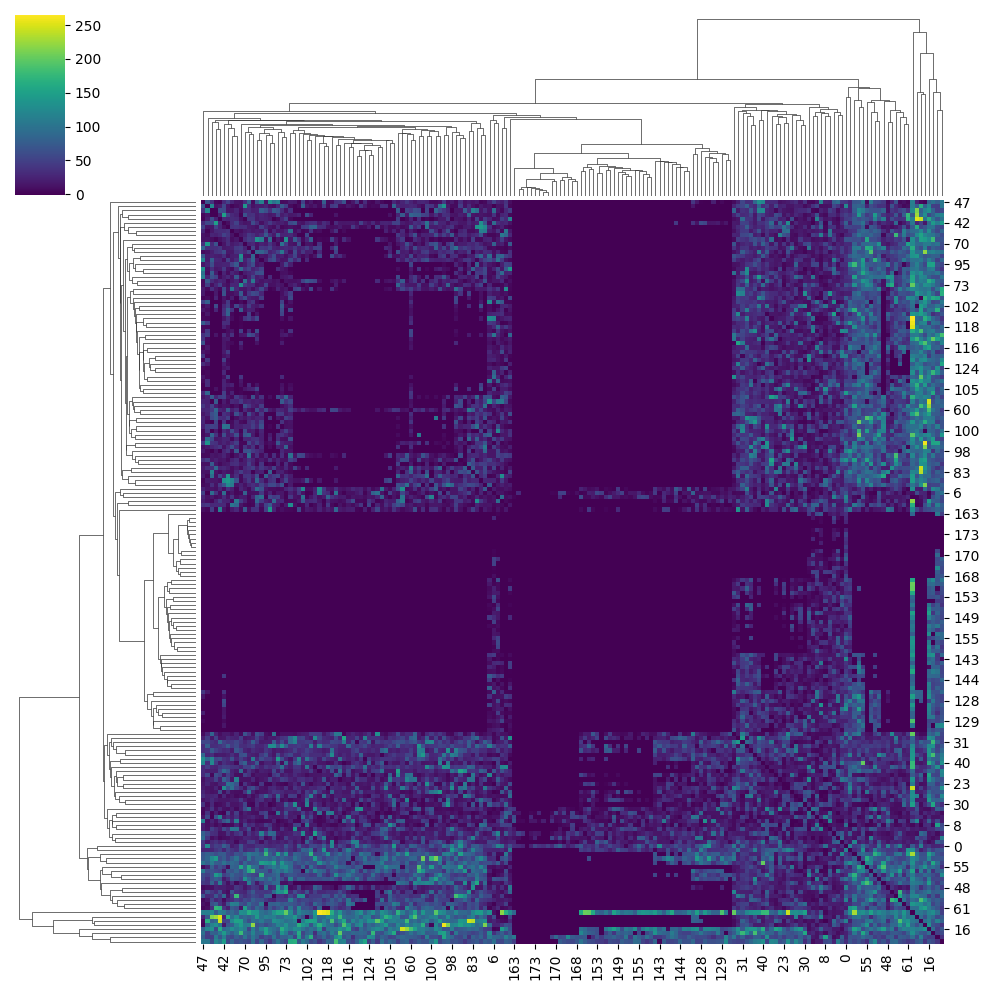

In [253]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Perform hierarchical clustering
cluster = sns.clustermap(distance_mat, method='average', cmap="viridis")
plt.show()
cluster.savefig("HG00621_read2read.png")

In [202]:
# ! pip3 install -U scikit-learn

ValueError: Number of labels is 179. Valid values are 2 to n_samples - 1 (inclusive)

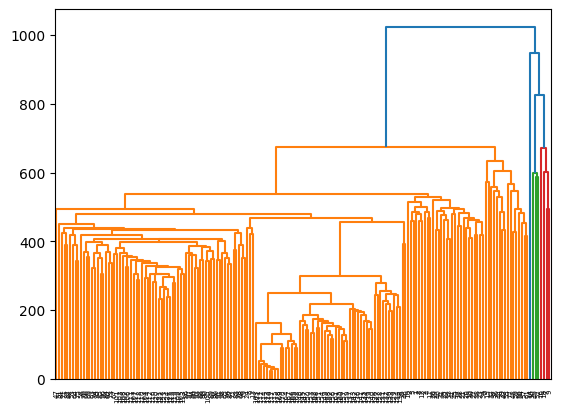

In [233]:
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt


# # Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_mat, method='average')  # Choose your linkage method

# # Create a dendrogram
dendrogram = sch.dendrogram(linkage_matrix)

# Extract the cluster assignments for each data point
# n_clusters = len(set(dendrogram['color_list']))
# cluster_assignments = sch.fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')


threshold = 0.5  # Adjust as needed

for threshold in [0.5]:
    clusters = sch.fcluster(linkage_matrix, threshold, criterion='distance')

    # Calculate silhouette scores for each data point
    silhouette_avg = silhouette_samples(distance_mat, clusters)
    
    # Print silhouette scores
    # for i, score in enumerate(silhouette_avg):
    #     print(f"Data point {i + 1}: Silhouette Score = {score:.2f}")
    
    # Calculate the mean silhouette score for all data points
    mean_silhouette_score = np.mean(silhouette_avg)
    print(f"Mean Silhouette Score = {mean_silhouette_score:.2f}")

# Visualize the dendrogram with cluster colors
# sch.dendrogram(linkage_matrix, color_threshold=0)
# plt.show()


In [226]:
set(dendrogram['color_list'])

{'C0', 'C1', 'C2', 'C3'}

In [218]:
np.linspace(0.1,0.9,9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# graph approach

In [27]:
filename = './MT_anchor_graphical_genome_k31_withannotation.gfa.gz'
graph = AGG.GraphicalGenome(filename)

In [28]:
# exclude D loop
spos = 577
epos = 16023
nodelist = sorted(graph.anchor.keys())
for i, node in enumerate(nodelist):
    p = int( graph.anchor[node]["pos"])
    if p > spos:
        n = nodelist[i]
        print(n, graph.anchor[n]['seq'])
        break
for i, node in enumerate(nodelist):
    p = int( graph.anchor[node]["pos"])
    if p > epos:
        n = nodelist[i-1]
        print(n, graph.anchor[nodelist[i-1]]['seq'])
        break

A000021 AAACAAATAGGTTTGGTCCTAGCCTTTCTAT
A000516 GCTAAGATTCTAATTTAAACTATTCTCTGTT


In [29]:
# load raw reads
def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained.
        The resulting sequences are 0-indexed! """
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rb')
    else:
        fp = open(filename, 'rb')
    # split at headers
    data = fp.read().decode().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        sequences.append(''.join(lines))
    return (headers, sequences)

In [30]:
headers, reference = loadFasta('../../../Mitochondrial/MitoHifi/Mitochondrial/NC_012920.1.fasta')
reference = reference[0]

In [31]:
for i in range(5,11,2):
    print(i)

5
7
9


In [32]:
for k in range(5,21,2):
    kmer = reference[:k]
    count = 0
    for i in range(len(reference) - k + 1):
        seq = reference[i:i+k]
        if kmer == seq:
            count += 1
    if count == 1:
        print(k)
        break

7


In [33]:
headers, reads = loadFasta('../../HG00621.fasta')

In [34]:
R_dict = dict(zip(headers, reads))

In [35]:
sanchorseq = "AAACAAATAGGTTTGGTCCTAGCCTTTCTAT"
eanchorseq = "GCTAAGATTCTAATTTAAACTATTCTCTGTT"

In [36]:
Mapping = {}
Numts = []
is_circular = 0
for readname, seq in R_dict.items():
    spos = seq.find(sanchorseq)
    epos = seq.find(eanchorseq)
    if spos == -1 or epos == -1:
        Numts.append(readname)
        continue
    else:
        is_circular += 1
is_circular


86

In [37]:
len(set(Numts))

122